# TRGAN: Bank transaction conditional generation.

### Kirill Zakharov

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

from TRGAN.TRGAN_main import *
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan_train
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *

plt.style.use('ggplot')

### Import data

In [2]:
data = pd.read_csv('Data/data_uk_clean.csv')

In [3]:
data.head()

,unnamed: 0,index,account_id,amount,balance,date,description,flag,id,type,age,datetime,month,day,dow,year,dtme,tcode,td
0,28979,0,0014d0ef29aa9f93,-45.66,228.34,2017-04-24 11:00:00.000000,Energy,Utility Bill,38a21d894127b49d,Debit,-1,2017-04-24 11:00:00.000000,4,24,0,2017,6,Energy__Utility Bill__Debit,0.0
1,30006,1,0014d0ef29aa9f93,2842.27,3070.61,2017-04-24 17:36:55.000000,Monthly,Income,3941e50e4613a49a,Credit,-1,2017-04-24 17:36:55.000000,4,24,0,2017,6,Monthly__Income__Credit,0.0
2,32220,2,0014d0ef29aa9f93,-167.25,2903.36,2017-04-25 16:00:00.000000,Credit Card Payment,Credit Card,c09e8105dcfc85b7,Debit,-1,2017-04-25 16:00:00.000000,4,25,1,2017,5,Credit Card Payment__Credit Card__Debit,0.0
3,35526,3,0014d0ef29aa9f93,-40.58,2862.78,2017-04-27 16:00:00.000000,Water Bill,Utility Bill,81e4ffc8df86920e,Debit,-1,2017-04-27 16:00:00.000000,4,27,3,2017,3,Water Bill__Utility Bill__Debit,2.0
4,94259,4,0014d0ef29aa9f93,-43.16,2819.62,2017-05-23 17:00:00.000000,Energy,Utility Bill,c0ddd8f8a923d40f,Debit,-1,2017-05-23 17:00:00.000000,5,23,1,2017,8,Energy__Utility Bill__Debit,26.0


In [4]:
data.shape

(100000, 19)

### Filter data for train

In [5]:
data = data.rename(columns={"account_id": 'customer', 'tcode': 'mcc', 'datetime': 'transaction_date'})

data = data[['customer', 'mcc', 'transaction_date', 'amount']]

In [6]:
data.shape

(100000, 4)

In [7]:
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data = data.sort_values(by='transaction_date')
data = data.reset_index(drop=True)

In [8]:
data.head()

,customer,mcc,transaction_date,amount
0,8881aff1345aed7d,Tesco Mobile Mobile__Utility Bill__Debit,2017-04-01 06:00:00,-15.00
1,181832d883269012,Water Bill__Utility Bill__Debit,2017-04-01 06:00:00,-34.25
2,aa1b1a1ced0e584a,O2 Mobile__Utility Bill__Debit,2017-04-01 06:00:00,-33.00
3,b5933a2e1ded9f2d,O2 Mobile__Utility Bill__Debit,2017-04-01 06:00:00,-33.00
4,b9e499f12cfa7eb4,Virgin Media Broadband__Utility Bill__Debit,2017-04-01 06:00:00,-44.00


In [9]:
le = LabelEncoder()
data['mcc'] = le.fit_transform(data['mcc'])

In [10]:
data.shape

(100000, 4)

In [11]:
synth_banksformer = pd.read_csv('Data/synth_banksformer_uk.csv')
synth_banksformer['date'] = pd.to_datetime(synth_banksformer['date'])

synth_banksformer = synth_banksformer.rename(columns={'tcode': 'mcc', 'date': 'transaction_date', 'account_id': 'customer'})
synth_banksformer['mcc'] = le.fit_transform(synth_banksformer['mcc'])

synth_banksformer = synth_banksformer[['mcc', 'transaction_date', 'customer', 'amount']]

deltas_by_clients_banksformer = synth_banksformer.groupby('customer')['transaction_date'].apply(lambda x: (x - x.shift()).dt.days.values[1:])

### Initialize all constants

In [12]:
'''
FEATURES NAMES
'''
cat_features = ['mcc']
cont_features = ['amount']
date_feature = ['transaction_date']
client_info = ['customer']

# data_cat = data[cat_features] 

'''
DIMENSIONS
'''
dim_X_cat = len(cat_features)
dim_X_cont = len(cont_features)
dim_X_date = 4
dim_Xoh = 25 # dimension of X one hot embeddings
dim_Xcl = 4  # dimension of client's info embeddings
dim_Vc_h = 6 # dimension of conditional vector
dim_bce = 5 # dimension of the behaviour client encoding
dim_Vc = dim_Vc_h + dim_X_date
dim_X_emb = dim_Xoh + dim_X_cont + dim_Xcl
dim_noise = 5
# data_dim = len(data_transformed[0])

'''
LEARNING RATES
'''
lr_E_oh = 1e-3
lr_E_cl = 1e-3
lr_E_Vc = 1e-3

'''
SAVE DIRECTORY
'''
DIRECTORY = 'Pretrained_model/'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Create OneHot representation of all categorical features $X_{oh}$ of dimension $d_{X_{oh}}$

In [13]:
experiment_id = 'uk_3'
load = True

In [14]:
X_oh = onehot_emb_categorical(data, cat_features)

### Create embeddings of the $X_{oh}$

In [15]:
X_oh_emb, encoder_onehot, decoder_onehot = trgan_train.create_cat_emb(X_oh,dim_Xoh, lr_E_oh, epochs=20, batch_size=2**7, load=load,\
                directory=DIRECTORY, names=[f'TRGAN_E_oh_exp_{experiment_id}.pkl', f'TRGAN_D_oh_exp_{experiment_id}.pkl', f'X_oh_emb_exp_{experiment_id}.npy'])

### Create embeddings of the $X_{cont}$

In [16]:
X_cont, scaler_cont = preprocessing_cont(data, cont_features, type_scale='CBNormalize')

### Create embeddings of the $X_{cl}$

In [17]:
X_cl, encoder_cl_emb, decoder_cl_emb, scaler_cl_emb, label_encoders = trgan_train.create_client_emb(dim_Xcl, data, client_info, dim_Xcl, lr_E_cl, epochs=20, batch_size=2**7,\
            load=load, directory=DIRECTORY, names=[f'TRGAN_E_cl_{experiment_id}.pkl',\
            f'TRGAN_D_cl_{experiment_id}.pkl', f'X_cl_{experiment_id}.npy', f'scaler_{experiment_id}.joblib', f'label_enc_{experiment_id}.joblib'])

In [18]:
X_emb, scaler_emb = create_embeddings(X_cont, X_oh_emb, X_cl)

### Create conditional vector $v$

In [19]:
cond_vector, synth_time, date_transformations, behaviour_cl_enc, encoder, deltas_by_clients, synth_deltas_by_clients =\
            trgan_train.create_conditional_vector(data, X_emb, date_feature, 'initial', dim_Vc_h, dim_bce, \
            name_client_id='customer', name_agg_feature='amount', lr_E_Vc=lr_E_Vc, epochs=20, batch_size=2**7, model_time='poisson', n_splits=2, load=load,\
            directory=DIRECTORY, names=[f'TRGAN_E_Vc_{experiment_id}.pkl', f'Vc_{experiment_id}.npy', f'BCE_{experiment_id}.npy'])

In [20]:
# _, deltas_by_clients, synth_deltas_by_clients = generate_synth_time(data, 'customer', 'transaction_date', model='normal', n_splits=2)

In [21]:
print(f'Dim X_emb: {X_emb.shape} || Dim V_c: {cond_vector.shape}')

Dim X_emb: (100000, 30) || Dim V_c: (100000, 10)


In [61]:
real_deltas = np.hstack(deltas_by_clients.values)
synth_pois_deltas = np.hstack(synth_deltas_by_clients)
synth_deltas_banksformer = np.hstack(deltas_by_clients_banksformer)

real_deltas = real_deltas[np.where(real_deltas < np.quantile(real_deltas, 0.98))[0]].astype(int)
synth_pois_deltas = synth_pois_deltas[np.where(synth_pois_deltas < np.quantile(real_deltas, 0.98))[0]].astype(int)
synth_deltas_banksformer = synth_deltas_banksformer[np.where(synth_deltas_banksformer < np.quantile(real_deltas, 0.98))[0]].astype(int)

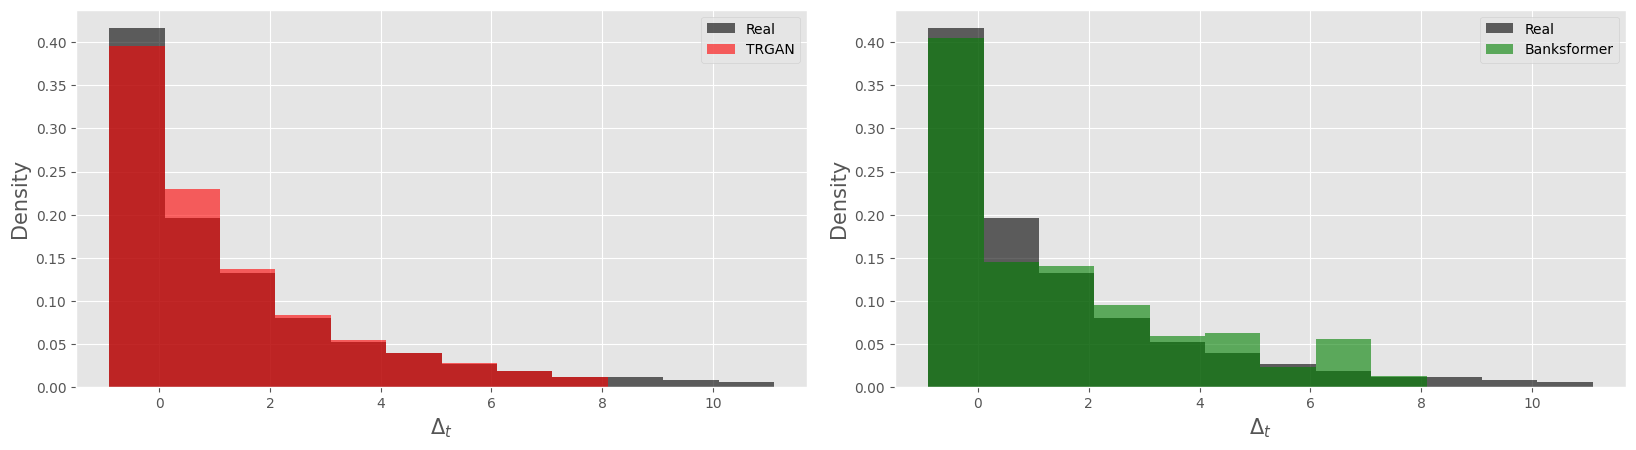

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

axs[0].hist(real_deltas, alpha=0.6, bins=np.arange(-1, 12) + 0.1, label='Real', density=True, color='black')
axs[0].hist(synth_pois_deltas, alpha=0.6, bins=np.arange(-1, 12) + 0.1, label='TRGAN', density=True, color='red')

axs[0].legend()
axs[0].set_xlabel('$\Delta_t$', fontsize=15)
axs[0].set_ylabel('Density', fontsize=15)
axs[0].locator_params(axis='x', integer=True)

axs[1].hist(real_deltas, alpha=0.6, bins=np.arange(-1, 12) + 0.1, label='Real', density=True, color='black')
axs[1].hist(synth_deltas_banksformer, alpha=0.6, bins=np.arange(-1, 12) + 0.1, label='Banksformer', density=True, color='green')

axs[1].legend()
axs[1].set_xlabel('$\Delta_t$', fontsize=15)
axs[1].set_ylabel('Density', fontsize=15)
axs[1].locator_params(axis='x', integer=True)

# plt.savefig('synth_deltas_uk.pdf', dpi=300)
plt.subplots_adjust(wspace=0.12)
plt.show()

### Train TRGAN

In [22]:
h_dim = 2**7
num_blocks_gen = 1
num_blocks_dis = 2

if load:
    generator = Generator(dim_noise + dim_Vc, dim_X_emb, h_dim, num_blocks_gen).to(DEVICE)
    supervisor = Supervisor(dim_X_emb + dim_Vc, dim_X_emb, h_dim, num_blocks_gen).to(DEVICE)

    generator.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl'))
    supervisor.load_state_dict(torch.load(f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl'))

    generator.eval()
    supervisor.eval()

    loss_array = np.load(f'loss_array_exp_{experiment_id}.npy')

else:
    generator, supervisor, loss_array, discriminator, discriminator2 = train_generator(X_emb, cond_vector, dim_Vc, dim_X_emb, dim_noise, batch_size=2**8,\
                                                    lr_rates=[7e-4, 7e-4, 7e-4, 7e-4], num_epochs=20, num_blocks_gen=num_blocks_gen, num_blocks_dis=num_blocks_dis, h_dim=h_dim)
    
    torch.save(generator.state_dict(), f'{DIRECTORY}TRGAN_generator_exp_{experiment_id}.pkl')
    torch.save(supervisor.state_dict(), f'{DIRECTORY}TRGAN_supervisor_exp_{experiment_id}.pkl')

    np.save(f'loss_array_exp_{experiment_id}.npy', loss_array)

    generator.eval()
    supervisor.eval()

### Loss functions

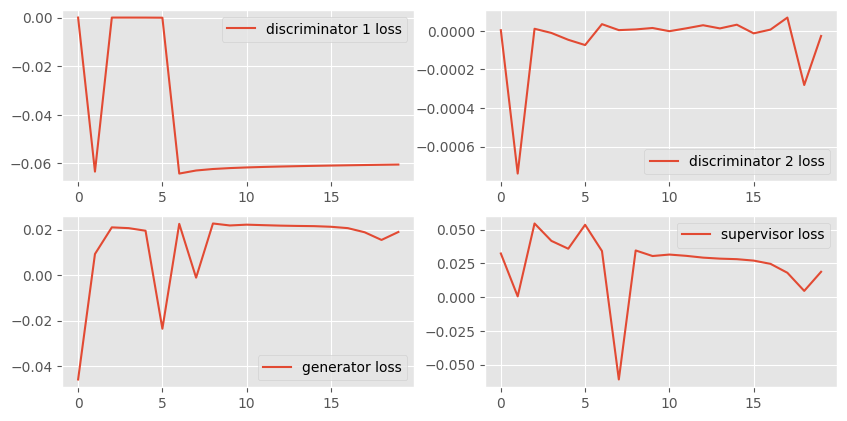

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].plot(np.array(loss_array).T[0], label='discriminator 1 loss')
axs[0, 1].plot(np.array(loss_array).T[1], label='discriminator 2 loss')
axs[1, 0].plot(np.array(loss_array).T[2], label='generator loss')
axs[1, 1].plot(np.array(loss_array).T[3], label='supervisor loss')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.show()

In [24]:
from pytorch_model_summary import summary

print(summary(generator, torch.zeros((512, dim_noise+dim_Vc)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1           [512, 15]           2,048           2,048
       LeakyReLU-2          [512, 128]               0               0
       LayerNorm-3          [512, 128]             256             256
          Linear-4          [512, 128]           4,128           4,128
       LeakyReLU-5           [512, 32]               0               0
          Linear-6          [512, 128]           4,128           4,128
          Linear-7          [512, 128]           4,128           4,128
          Linear-8           [512, 96]          12,416          12,416
       LayerNorm-9          [512, 128]             256             256
         Linear-10          [512, 128]          16,512          16,512
      LeakyReLU-11          [512, 128]               0               0
        Dropout-12          [512, 128]               0               0
     

In [25]:
# print(summary(discriminator, torch.zeros((512, dim_X_emb+dim_Vc)), show_input=True))

### Generate synthetics

In [26]:
n_samples = len(X_emb[:])
synth_data, synth_time = sample(n_samples, generator, supervisor, dim_noise, cond_vector,\
                                X_emb, encoder, data, behaviour_cl_enc, date_feature, 'customer', time='initial', model_time='normal')

In [27]:
synth_df, synth_df_cat = inverse_transforms(n_samples, synth_data, synth_time, client_info, cont_features, X_oh, scaler_emb, scaler_cl_emb, scaler_cont,\
                    label_encoders, decoder_cl_emb, decoder_onehot, dim_Xcl, dim_X_cont, type_scale_cont='CBNormalize')

In [28]:
synth_df = synth_df.sort_values(by='transaction_date')
# synth_df['mcc'] = le.inverse_transform(synth_df['mcc'])
# data['mcc'] = le.inverse_transform(data['mcc'])
synth_df

,customer,amount,transaction_date,mcc
0,f5b5d4a4743ae052,-11.30,2017-04-01 06:00:00,34
25,03bcc5b369e0d8f8,-26.81,2017-04-01 06:00:00,41
26,a0c124b157bc53ff,-1194.26,2017-04-01 06:00:00,27
27,0b5f9b6128f91a58,-84.87,2017-04-01 06:00:00,8
28,c62b843a024c46eb,-30.99,2017-04-01 06:00:00,41
...,...,...,...,...
99969,c1438a4910fb56f9,-1500.30,2017-05-25 20:00:00,19
99970,6224502f71db9198,-409.13,2017-05-25 20:00:00,7
99971,a710cc1dc2d4727f,-27.30,2017-05-25 20:00:00,23
99961,c522efb865d4721b,-32.78,2017-05-25 20:00:00,41


## Quality Assessment

In [29]:
X_gr = []
X_gr.append(X_emb[:, :21].T[:7])
X_gr.append(X_emb[:, :21].T[7:14])
X_gr.append(X_emb[:, :21].T[14:21])
X_gr = np.array(X_gr)

X_gr_s = []
X_gr_s.append(synth_data[:, :21].T[:7])
X_gr_s.append(synth_data[:, :21].T[7:14])
X_gr_s.append(synth_data[:, :21].T[14:21])
X_gr_s = np.array(X_gr_s)

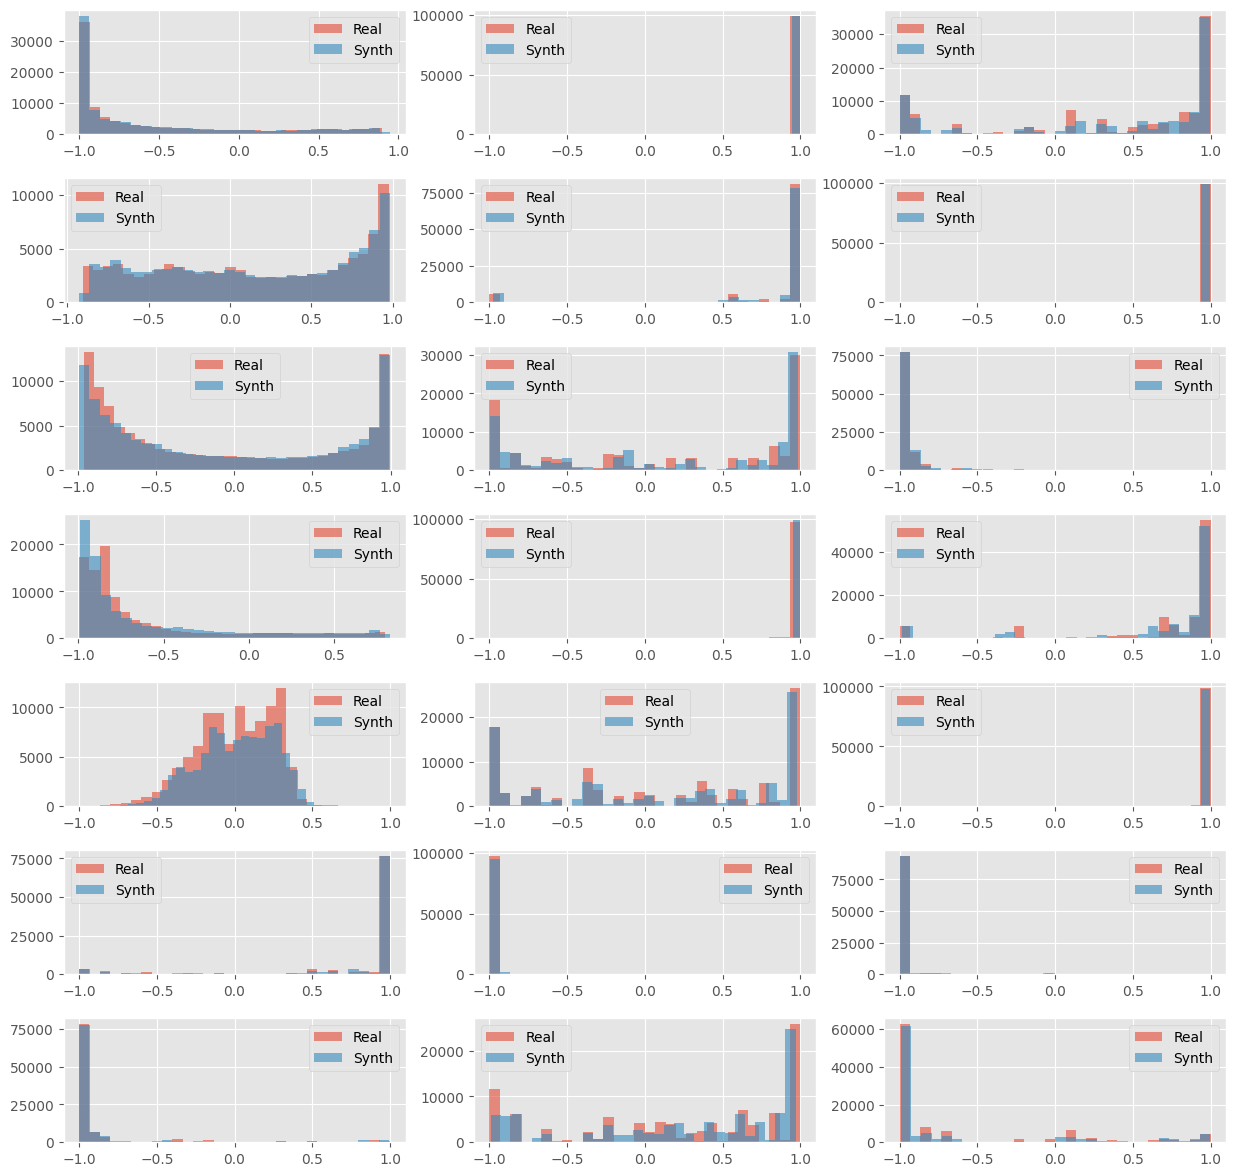

In [30]:
fig, axs = plt.subplots(7, 3, figsize=(15, 15), dpi=100)

for i in range(7):
    for j in range(3):
        axs[i, j].hist(X_gr[j, i], bins=30, label='Real', alpha=0.6)
        axs[i, j].hist(X_gr_s[j, i], bins=30, label='Synth', alpha=0.6)

        axs[i, j].legend()

plt.subplots_adjust(hspace=0.35)
# plt.savefig('results_synth_exp4.png', dpi=300)
plt.show()

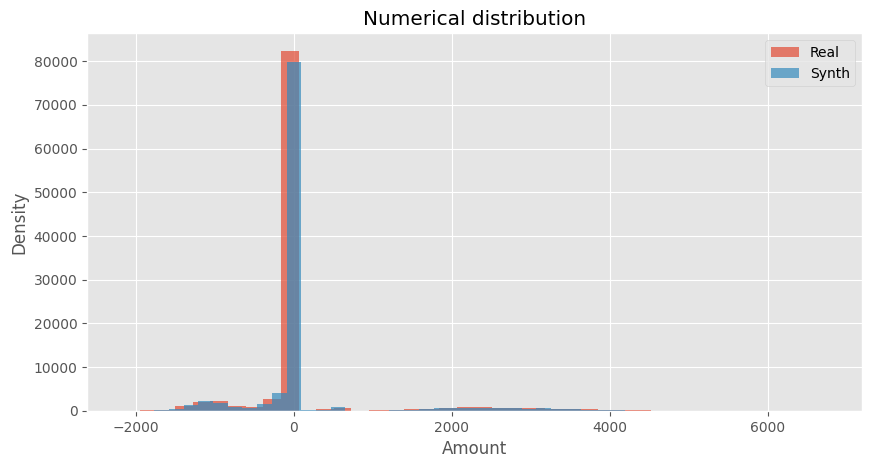

In [31]:
plt.subplots(figsize=(10, 5), dpi=100)

data['amount'].hist(bins=40, label='Real', alpha=0.7)
synth_df['amount'].hist(bins=40, label='Synth', alpha=0.7)

plt.legend()
plt.title('Numerical distribution')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.show()

### Compare mcc

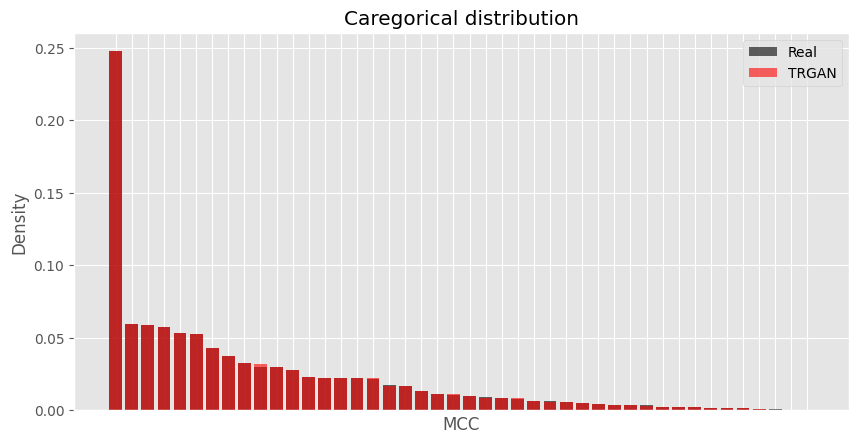

In [32]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.bar(np.sort(data['mcc'].value_counts().index.values).astype(str), data['mcc'].value_counts().values/(np.sum(data['mcc'].value_counts().values)),\
                                                    color='black', alpha=0.6, label='Real')
plt.bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str), synth_df['mcc'].value_counts().values/(np.sum(synth_df['mcc'].value_counts().values)),\
                                                    color='red', alpha=0.6, label='TRGAN')

# plt.xticks(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.legend()
plt.title('Caregorical distribution')
plt.ylabel('Density')
plt.xlabel('MCC')
plt.show()

In [43]:
metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')


metadata.add_column(
    column_name='customer',
    sdtype='categorical')


metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

In [44]:
from sdmetrics.single_table import NewRowSynthesis

NewRowSynthesis.compute(
    # real_data=data.drop('index', axis=1),
    real_data=data,
    synthetic_data=synth_df,
    metadata=metadata,
    numerical_match_tolerance=0.01,
    synthetic_sample_size=10_000
)

0.973

In [45]:
evaluate_categorical(data_array=[data['mcc'], synth_df['mcc']], index=['Real', 'TRGAN'], data_cont_array=[data[['mcc', 'transaction_date']], synth_df[['mcc', 'transaction_date']]])

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.00000,1.00000,44.0,0.000000
TRGAN,0.99355,0.99234,44.0,0.281152


### Compare clients' features

In [50]:
# fig, axs = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

# axs[0].hist(data['customer'], alpha=0.7, label='Real', bins=40)
# axs[0].hist(synth_df['customer'], alpha=0.7, label='Synth', bins=40)

# axs[0].legend()
# axs[0].set_xticks(np.arange(0, len(data['customer'].value_counts()), 500), np.arange(0, len(data['customer'].value_counts()), 500))
# axs[0].set_title('Client id')

# axs[1].hist(data['terminal'], alpha=0.7, label='Real', bins=40)
# axs[1].hist(synth_df['terminal'], alpha=0.7, label='Synth', bins=40)

# axs[1].legend()
# axs[1].set_xticks(np.arange(0, len(synth_df['terminal'].value_counts()), 300), np.arange(0, len(synth_df['terminal'].value_counts()), 300))
# axs[1].set_title('Terminal id')
# plt.show()

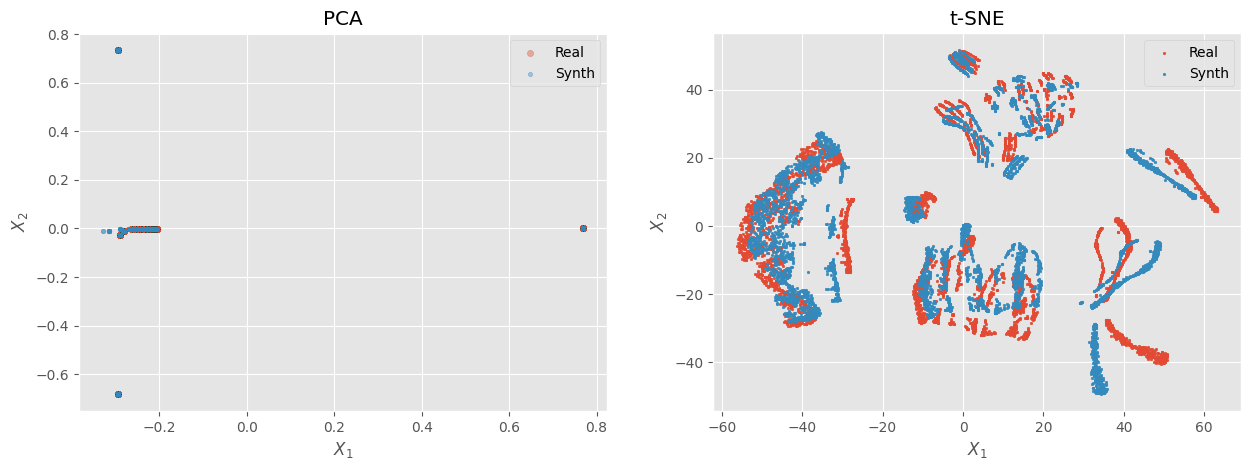

In [46]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca1 = PCA(n_components=2)
# pca2 = PCA(n_components=2)

data_transformed_pca = pca1.fit_transform(X_oh)
synth_pca = pca1.transform(synth_df_cat)
# data_transformed_pca = pca1.fit_transform(X_emb)
# synth_pca = pca2.fit_transform(synth_data)

tsne1 = TSNE(n_components=2, perplexity = 80)
tsne2 = TSNE(n_components=2, perplexity = 80)

idx_random = np.random.randint(0, len(X_emb), 5000)

data_transformed_tsne = tsne1.fit_transform(X_emb[idx_random])
synth_tsne = tsne2.fit_transform(synth_data[idx_random])


figure, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

axs[0].scatter(data_transformed_pca.T[0], data_transformed_pca.T[1], label='Real', alpha=0.4, s=20)
axs[0].scatter(synth_pca.T[0], synth_pca.T[1], label='Synth', alpha=0.4, s=10)

axs[0].legend()
axs[0].set_xlabel('$X_1$')
axs[0].set_ylabel('$X_2$')
axs[0].set_title('PCA')


axs[1].scatter(data_transformed_tsne.T[0], data_transformed_tsne.T[1], label='Real', s=3, alpha=1)
axs[1].scatter(synth_tsne.T[0], synth_tsne.T[1], label='Synth', s=3, alpha=1)

axs[1].legend()
axs[1].set_xlabel('$X_1$')
axs[1].set_ylabel('$X_2$')
axs[1].set_title('t-SNE')

plt.show()

## Comparison with other models

Prepare metadata for methods

In [33]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')

metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

Choose categorical columns for metrics calculation

In [34]:
cat_columns = ['mcc']

### Compare categorical columns

In [35]:
def copulagan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):
    
    if load:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load('CopulaGAN_uk.pkl')
    else:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save('CopulaGAN_uk.pkl')

    synth_copulagan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_copulagan = pd.get_dummies(synth_copulagan[cat_columns], columns=cat_columns)

    return synth_copulagan, synth_df_cat_copulagan

def ctgan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):

    if load:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load('CTGAN_uk.pkl')
    else:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save('CTGAN_uk.pkl')
 
    synth_ctgan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_ctgan = pd.get_dummies(synth_ctgan[cat_columns], columns=cat_columns)

    return synth_ctgan, synth_df_cat_ctgan

def compare_categorical_w_banksformer(data, synth_df, synth_df_cat, X_oh, metadata, cat_columns, synth_banks,\
                                    epochs=2, n_samples=10_000, comp_col='mcc', contig_cols=['mcc', 'customer'], load=False):
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

    axs[0, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 0].bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str),\
            synth_df['mcc'].value_counts().values/np.sum(synth_df['mcc'].value_counts().values), color='red', alpha=0.6, label='TRGAN')
    
    # axs[0, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[0, 0].legend()
    axs[0, 0].set_xlabel('Category', fontsize=15)
    axs[0, 0].set_ylabel('Density', fontsize=15)
#     axs[0, 0].set_title('TRGAN')


    axs[0, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 1].bar(np.sort(synth_ctgan['mcc'].value_counts().index.values).astype(str),\
            synth_ctgan['mcc'].value_counts().values/np.sum(synth_ctgan['mcc'].value_counts().values), color='lightblue', alpha=0.6, label='CTGAN')

    # axs[0, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[0, 1].legend()
    axs[0, 1].set_xlabel('Category', fontsize=15)
    axs[0, 1].set_ylabel('Density', fontsize=15)
#     axs[0, 1].set_title('CTGAN')


    axs[1, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[1, 0].bar(np.sort(synth_copulagan['mcc'].value_counts().index.values).astype(str),\
            synth_copulagan['mcc'].value_counts().values/np.sum(synth_copulagan['mcc'].value_counts().values), color='orange', alpha=0.6, label='CopulaGAN')

    # axs[1, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[1, 0].legend()
    axs[1, 0].set_xlabel('Category', fontsize=15)
    axs[1, 0].set_ylabel('Density', fontsize=15)
#     axs[1, 0].set_title('CopulaGAN')

    
    axs[1, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[1, 1].bar(np.sort(synth_banksformer['mcc'].value_counts().index.values).astype(str),\
            synth_banksformer['mcc'].value_counts().values/np.sum(synth_banksformer['mcc'].value_counts().values), color='green', alpha=0.6, label='Banksformer')
    
    # axs[1, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[1, 1].legend()
    axs[1, 1].set_xlabel('Category', fontsize=15)
    axs[1, 1].set_ylabel('Density', fontsize=15)
#     axs[1, 1].set_title('Banksformer')

    plt.subplots_adjust(hspace=0.15, wspace=0.12)
    # plt.savefig('synth_mcc_uk.pdf', dpi=300)
    # plt.savefig('synth_mcc_uk.png', dpi=300)
    plt.show()

    # display(evaluate_new_rows([data, synth_df, synth_ctgan, synth_copulagan, synth_banksformer],\
                # index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'], metadata=metadata))

    eval_cat = evaluate_categorical([data[comp_col], synth_df[comp_col], synth_ctgan[comp_col], synth_copulagan[comp_col], synth_banksformer[comp_col]],\
                                     index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'],\
    data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_ctgan[contig_cols], synth_copulagan[contig_cols], synth_banksformer[contig_cols]])

    return eval_cat

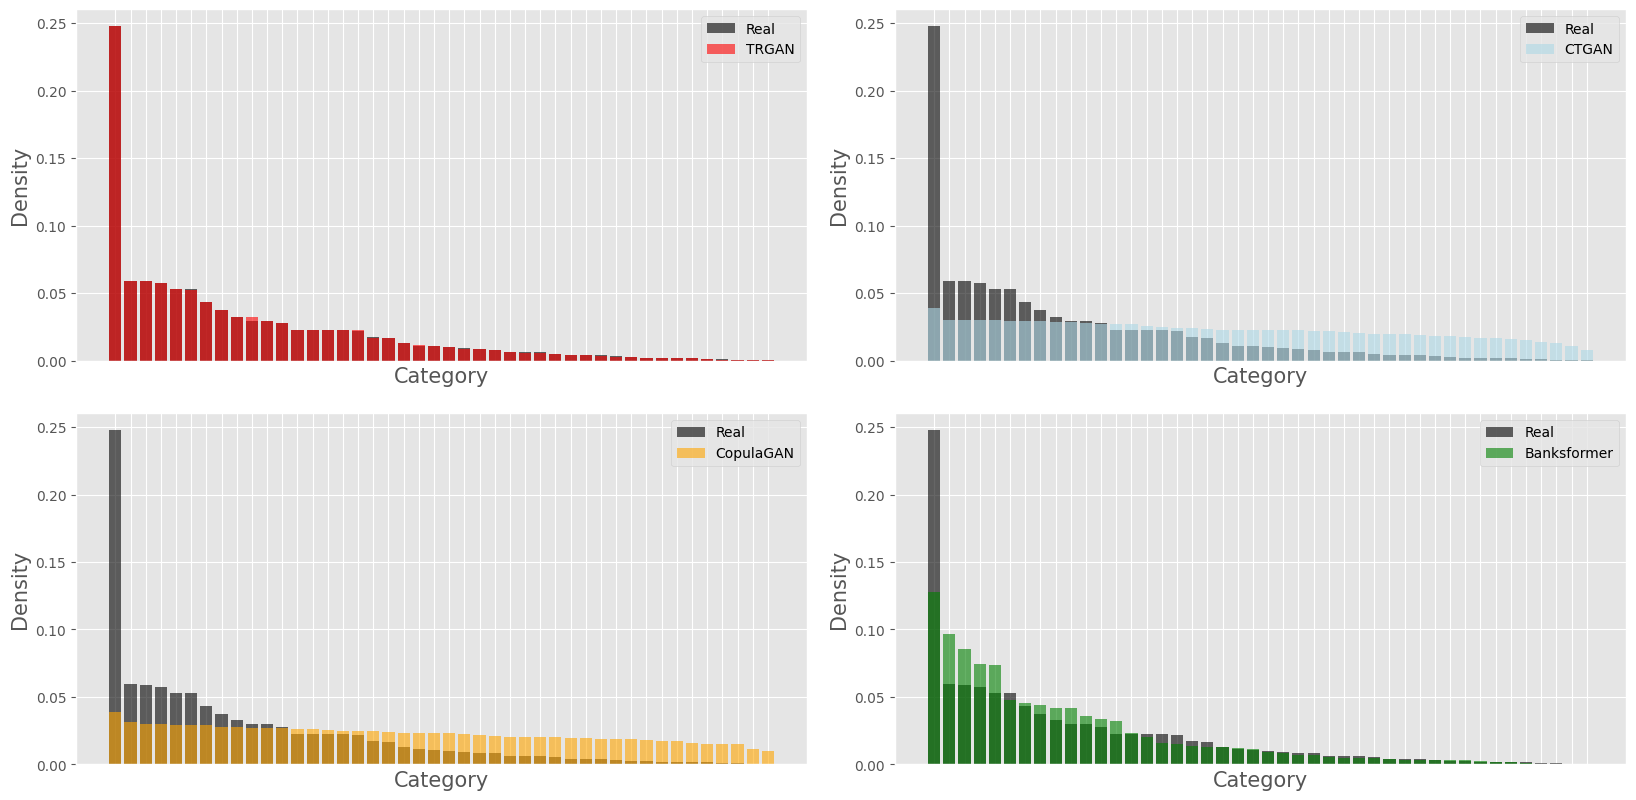

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.00000,1.00000,44.0,0.000000
TRGAN,0.99355,0.99234,44.0,0.281152
CTGAN,0.61853,0.00000,44.0,0.336047
CopulaGAN,0.61466,0.00000,44.0,0.340321
Banksformer,0.77099,0.00000,44.0,0.353755


In [39]:
compare_categorical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df[['mcc', 'amount', 'transaction_date']], synth_df_cat, X_oh, metadata, \
            cat_columns, synth_banksformer.sample(len(data))[['mcc', 'amount', 'transaction_date']],\
            epochs=1, n_samples=len(data), comp_col='mcc', contig_cols=['mcc', 'transaction_date'], load=True)

### Compare numerical columns

In [40]:
def compare_numerical_w_banksformer(data, synth_df, metadata, cat_columns, synth_banks, epochs=10, n_samples=10_000,\
                                    comp_col='amount', load=False, type_comp='log_amount', data_customer=''):
    
    """_summary_

    Returns:
       Object: Return graphs and table with metrics

    Types of visuals:
        - Log amount: log_amount
        - Cash flow: cash_flow

    """
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    if type_comp == 'log_amount':

        data = copy.deepcopy(data)
        synth_df = copy.deepcopy(synth_df)
        data[comp_col] = abs(data[comp_col])
        synth_df[comp_col] = abs(synth_df[comp_col])
        synth_ctgan[comp_col] = abs(synth_ctgan[comp_col])
        synth_copulagan[comp_col] = abs(synth_copulagan[comp_col])
        synth_banksformer[comp_col] = abs(synth_banksformer[comp_col])

        hist_real = np.histogram(np.log1p(data[comp_col]), normed=True, bins=40)

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(np.log1p(synth_df[comp_col]), bins=40, label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend()
        axs[0, 0].set_xlabel('Log amount', fontsize=15)
        axs[0, 0].set_ylabel('Density', fontsize=15)
        axs[0, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(np.log1p(synth_ctgan[comp_col]), bins=40, label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend()
        axs[0, 1].set_xlabel('Log amount', fontsize=15)
        axs[0, 1].set_ylabel('Density', fontsize=15)
        axs[0, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(np.log1p(synth_copulagan[comp_col]), bins=40, label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend()
        axs[1, 0].set_xlabel('Log amount', fontsize=15)
        axs[1, 0].set_ylabel('Density', fontsize=15)
        axs[1, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[1, 0].set_title('CopulaGAN')

        axs[1, 1].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 1].hist(np.log1p(synth_banksformer[comp_col]), bins=40, label='Banksformer', alpha=0.7, density=True, color='green')
        axs[1, 1].legend()
        axs[1, 1].set_xlabel('Log amount', fontsize=15)
        axs[1, 1].set_ylabel('Density', fontsize=15)
        axs[1, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.15)
        # plt.savefig('synth_amount_uk.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical([np.log1p(data[comp_col]), np.log1p(synth_df[comp_col]), np.log1p(synth_ctgan[comp_col]),\
                                       np.log1p(synth_copulagan[comp_col]), np.log1p(synth_banksformer[comp_col])],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'])
        
        return eval_num
    
    elif type_comp == 'cash_flow':

        data = copy.deepcopy(data)
        synth_df = copy.deepcopy(synth_df)
        data['month'] = data['transaction_date'].dt.month
        synth_banksformer['month'] = synth_banksformer['transaction_date'].dt.month
        synth_df['month'] = synth_df['transaction_date'].dt.month
        synth_ctgan['month'] = synth_ctgan['transaction_date'].dt.month
        synth_copulagan['month'] = synth_copulagan['transaction_date'].dt.month
        # synth_tvae['month'] = synth_tvae['transaction_date'].dt.month

        data = pd.concat([data, data_customer], axis=1)
        synth_ctgan = pd.concat([synth_ctgan, data_customer], axis=1)
        synth_copulagan = pd.concat([synth_copulagan, data_customer], axis=1)

        

        cash_flow_real = (data.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_banks = (synth_banksformer.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_trgan = (synth_df.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_ctgan = (synth_ctgan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_copulagan = (synth_copulagan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()

        q = np.quantile(cash_flow_real, 0.95)

        cash_flow_real = cash_flow_real.iloc[np.where((cash_flow_real <= q) & (cash_flow_real >= -q))[0]]
        cash_flow_banks = cash_flow_banks.iloc[np.where((cash_flow_banks <= q) & (cash_flow_banks >= -q))[0]]
        cash_flow_trgan = cash_flow_trgan.iloc[np.where((cash_flow_trgan <= q) & (cash_flow_trgan >= -q))[0]]
        cash_flow_ctgan = cash_flow_ctgan.iloc[np.where((cash_flow_ctgan <= q) & (cash_flow_ctgan >= -q))[0]]
        cash_flow_copulagan = cash_flow_copulagan.iloc[np.where((cash_flow_copulagan <= q) & (cash_flow_copulagan >= -q))[0]]
        
        min_length = np.min(list(map(lambda x: len(x), [cash_flow_real, cash_flow_trgan, cash_flow_banks, cash_flow_ctgan, cash_flow_copulagan])))

        cash_flow_real = pd.Series(random.sample(cash_flow_real.values.tolist(), min_length))
        cash_flow_banks = pd.Series(random.sample(cash_flow_banks.values.tolist(), min_length))
        cash_flow_trgan = pd.Series(random.sample(cash_flow_trgan.values.tolist(), min_length))
        cash_flow_ctgan = pd.Series(random.sample(cash_flow_ctgan.values.tolist(), min_length))
        cash_flow_copulagan = pd.Series(random.sample(cash_flow_copulagan.values.tolist(), min_length))

        hist_real = np.histogram(cash_flow_real, normed=True, bins=40)

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(cash_flow_trgan, bins=40, label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend()
        axs[0, 0].set_xlabel('Month cash flow', fontsize=15)
        axs[0, 0].set_ylabel('Density', fontsize=15)
        # axs[0, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(cash_flow_ctgan, bins=40, label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend()
        axs[0, 1].set_xlabel('Month cash flow', fontsize=15)
        axs[0, 1].set_ylabel('Density', fontsize=15)
        # axs[0, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(cash_flow_copulagan, bins=40, label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend()
        axs[1, 0].set_xlabel('Month cash flow', fontsize=15)
        axs[1, 0].set_ylabel('Density', fontsize=15)
        # axs[1, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[1, 0].set_title('CopulaGAN')

        axs[1, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 1].hist(cash_flow_banks, bins=40, label='Banksformer', alpha=0.7, density=True, color='green')
        axs[1, 1].legend()
        axs[1, 1].set_xlabel('Month cash flow', fontsize=15)
        axs[1, 1].set_ylabel('Density', fontsize=15)
        # axs[1, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 3e-6))
        # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.15)
        # plt.savefig('synth_cashflow_uk.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical([cash_flow_real, cash_flow_trgan, cash_flow_ctgan, cash_flow_copulagan, cash_flow_banks],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'])
        
        return eval_num
    
    else:
        print('Choose the type of comparison')

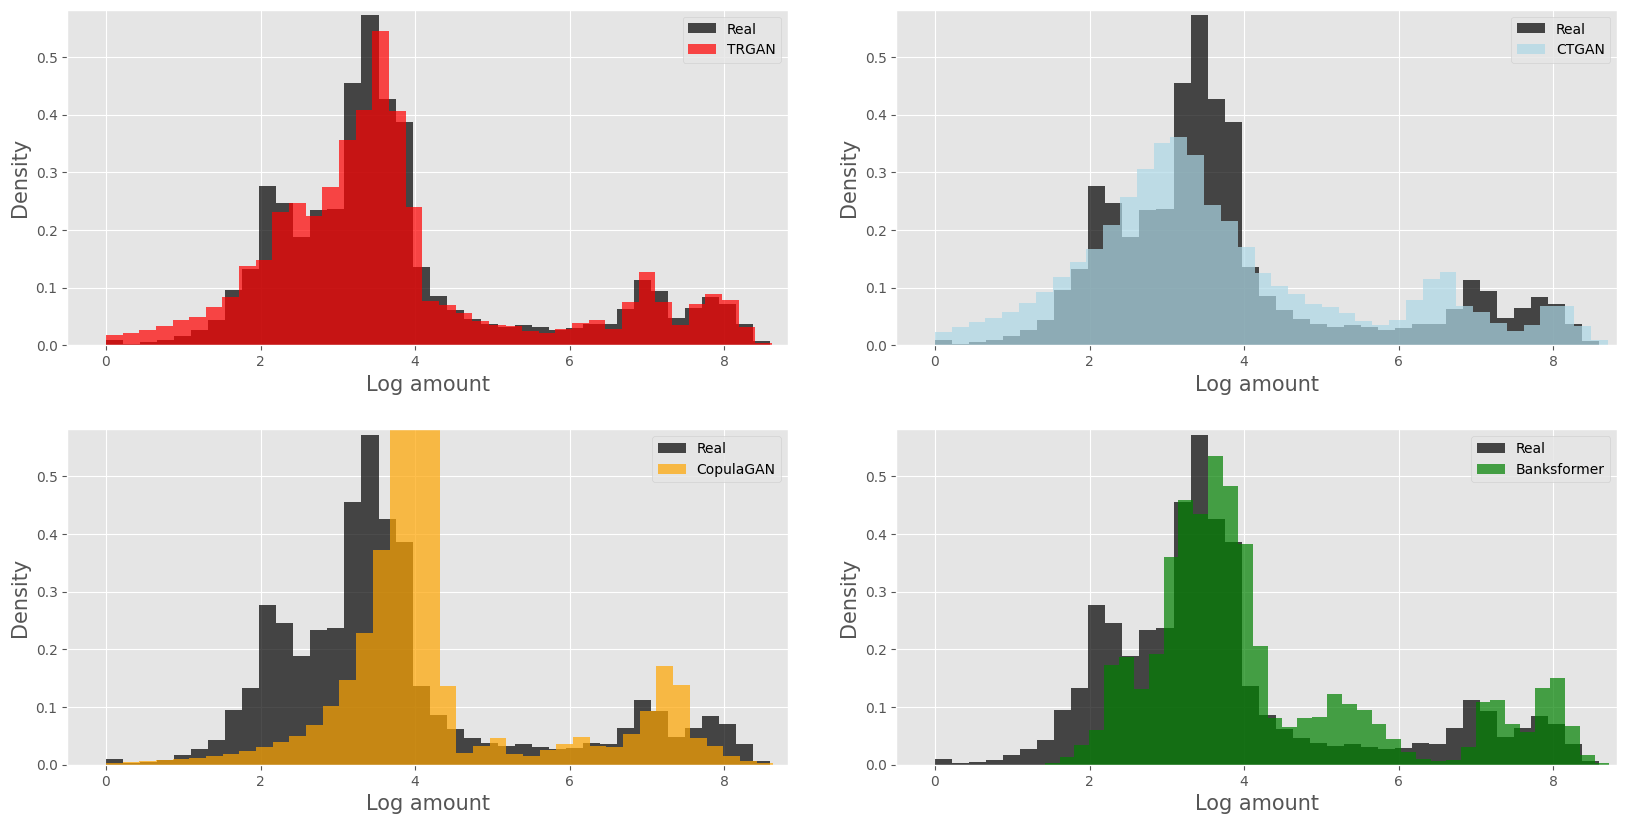

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,3.802952,1.692282,0.558295,1.106460,0.000000,0.00000,0.000000
TRGAN,3.727875,1.765614,0.460806,0.968261,0.132386,0.06215,0.081460
CTGAN,3.697740,1.838424,0.008516,0.758231,0.229654,0.09750,0.276271
CopulaGAN,4.297961,1.355994,1.199706,1.040063,0.184838,0.38329,0.569250
Banksformer,4.256315,1.633994,0.296985,1.140948,0.194663,0.17040,0.453363


In [41]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df, metadata, cat_columns,\
                                synth_banksformer.sample(len(data)), epochs=1, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='log_amount', data_customer=data[['customer']])

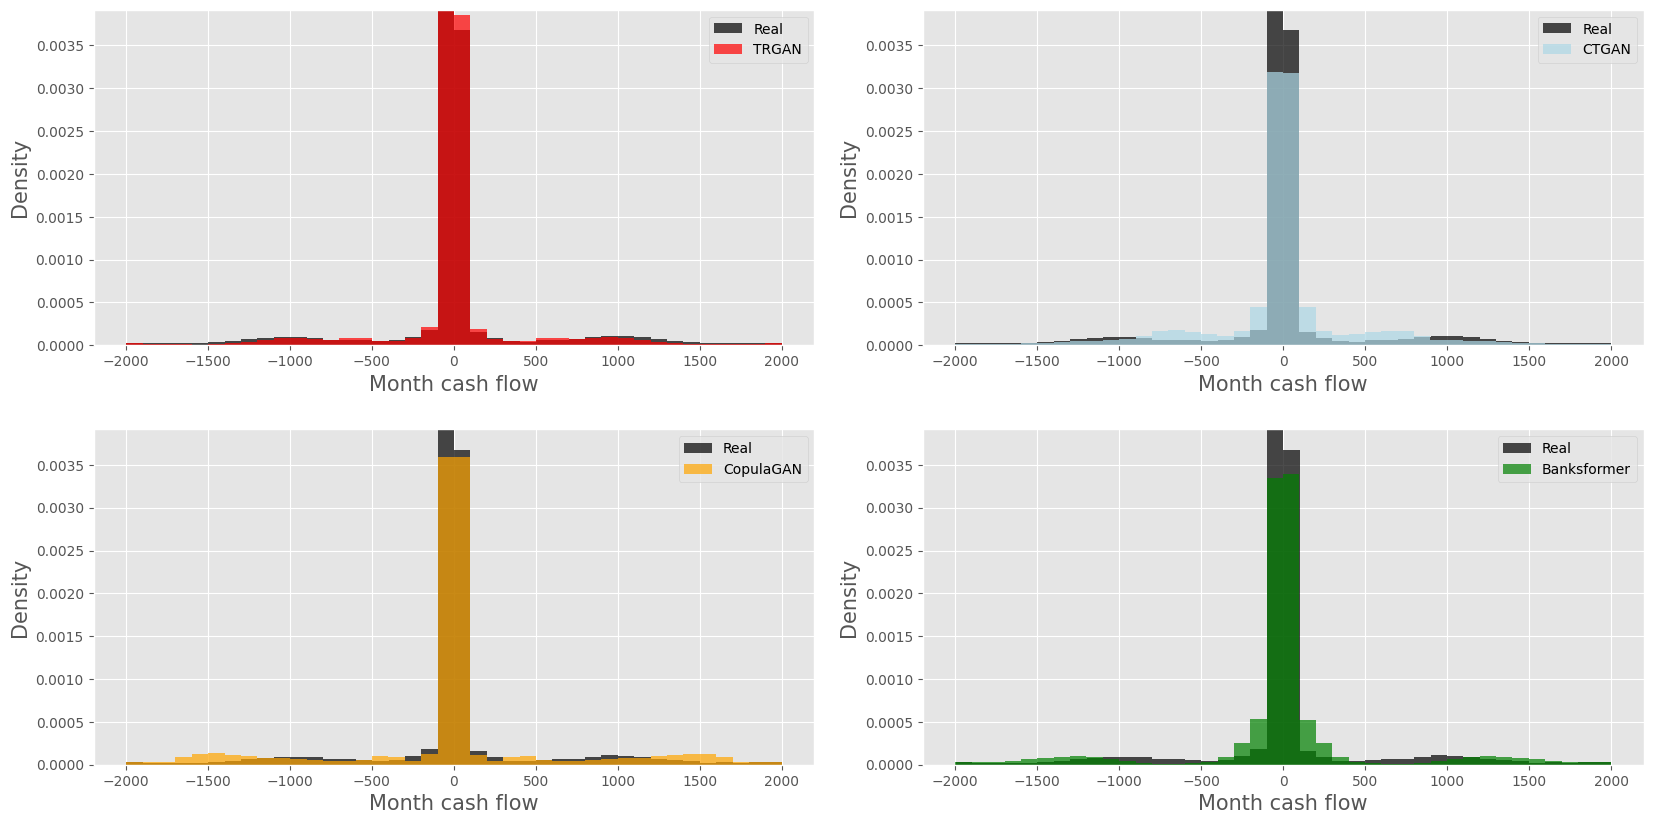

,Mean,Std,Kurtosis,Skewness,D_JS,KS2test,Wassertein distance
Real,6.130202,480.680028,5.179554,0.054352,inf,0.000000,0.000000
TRGAN,3.951807,402.732776,7.505963,0.070418,inf,0.027527,44.718394
CTGAN,0.350044,446.439067,4.663434,0.017747,inf,0.126267,64.787376
CopulaGAN,0.109696,613.741360,2.664850,-0.003844,inf,0.050369,89.364494
Banksformer,0.025530,527.921126,4.717093,-0.000194,inf,0.053017,44.876704


In [39]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df, metadata, cat_columns,\
                                synth_banksformer.sample(len(data)), epochs=1, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='cash_flow', data_customer=data[['customer']])

In [34]:
# synth_df.to_csv(f'Synthetic_data_{experiment_id}.csv', index=False)
# synth_df_cat.to_csv(f'Synthetic_data_cat_{experiment_id}.csv', index=False)

In [52]:
def window_split(cl):
    cl_mcc_cplit = []
    for i in range(len(cl)-2):
        cl_mcc_cplit.append(cl.iloc[i:i+3].values)
    return cl_mcc_cplit

def join_in_one_array(array):
    res = []
    for i in array:
        for j in i:
            res.append(j)

    return res

In [276]:
def calculate_3_grams(data):
    split_data = data.groupby('customer')['mcc'].apply(lambda x: window_split(x))
    split_data = split_data.values
    split_data = join_in_one_array(split_data)

    split_data_df = pd.DataFrame(np.array(split_data), columns=['1', '2', '3'])
    split_data_df['ones'] = 1
    split_counts = split_data_df.groupby(['1', '2', '3']).count().sort_values(by='ones', ascending=False).iloc[:25].values.flatten()

    i_data = split_data_df.groupby(['1', '2', '3']).count().sort_values(by='ones', ascending=False).iloc[:25].index.values

    return i_data, split_counts


def calculate_3_grams_synth(data, idx_real):
    split_data = data.groupby('customer')['mcc'].apply(lambda x: window_split(x))
    split_data = split_data.values
    split_data = join_in_one_array(split_data)

    split_data_df = pd.DataFrame(np.array(split_data), columns=['1', '2', '3'])
    split_data_df['ones'] = 1

    idx_synth = split_data_df.groupby(['1', '2', '3']).count().sort_values(by='ones', ascending=False).iloc[:25].index
    
    split_counts = split_data_df.groupby(['1', '2', '3']).count().sort_values(by='ones', ascending=False).iloc[:25].loc[np.intersect1d(idx_synth,\
         idx_real)].sort_values(by='ones', ascending=False).values.flatten()

    i_data = split_data_df.groupby(['1', '2', '3']).count().sort_values(by='ones', ascending=False).iloc[:25].loc[np.intersect1d(idx_synth,\
         idx_real)].sort_values(by='ones', ascending=False).index.values

    return i_data, split_counts    

def calculate_idx_3_grams(i_data, all_comb):
    idx_real_pos = []

    for j in i_data:
        for i in range(len(all_comb)):
            if j == all_comb[i]:
                idx_real_pos.append(i)
                break
        else:
            continue

    return idx_real_pos

In [307]:
jensenshannon(real_3grams_count, trgan_3grams_count)

ValueError: operands could not be broadcast together with shapes (25,) (20,) 

In [310]:
real_3grams_count

array([1641,  948,  912,  690,  632,  612,  610,  594,  587,  578,  514,
        497,  438,  413,  392,  369,  344,  340,  293,  286,  281,  278,
        271,  267,  261])

In [ ]:
list(zip())

In [322]:
np.setdiff1d(real_3grams_idx, np.setdiff1d(real_3grams_idx, trgan_3grams_idx))

array([ 1592,  3454,  4370,  5057,  5215,  5268,  5270,  5275,  5278,
        5282,  5290,  5292,  5293,  5294,  5344,  5570,  6429,  9112,
       10311, 14304])

In [318]:
np.where(np.isin(np.setdiff1d(real_3grams_idx, trgan_3grams_idx), real_3grams_idx))

(array([0, 1, 2, 3, 4]),)

In [316]:
trgan_3grams_idx

[5278,
 5268,
 5292,
 10311,
 1592,
 5570,
 5275,
 5057,
 5290,
 3454,
 5215,
 6429,
 9112,
 14304,
 4370,
 5294,
 5293,
 5270,
 5344,
 5282]

In [309]:
trgan_3grams_count

array([3881,  830,  813,  624,  603,  501,  466,  443,  413,  408,  408,
        405,  396,  395,  389,  379,  376,  363,  277,  241])

In [308]:
pd.DataFrame(wasserstein_distance(real_3grams_count, trgan_3grams_count))

182.1700000000001

In [319]:
def compare_categorical_w_banksformer_3grams(data, synth_df, synth_df_cat, X_oh, metadata, cat_columns, synth_banks,\
                                    epochs=2, n_samples=10_000, comp_col='mcc', contig_cols=['mcc', 'customer'], load=False, data_customer=''):
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    synth_ctgan['customer'] = data_customer
    synth_copulagan['customer'] = data_customer
    # synth_copulagan['customer'] = data_customer

    real_3grams_idx, real_3grams_count = calculate_3_grams(data)
    trgan_3grams_idx, trgan_3grams_count = calculate_3_grams_synth(synth_df, real_3grams_idx)
    # ctgan_3grams_idx, ctgan_3grams_count = calculate_3_grams_synth(synth_ctgan, real_3grams_idx)
    # copulagan_3grams_idx, copulagan_3grams_count = calculate_3_grams_synth(synth_copulagan, real_3grams_idx)
    banks_3grams_idx, banks_3grams_count = calculate_3_grams_synth(synth_banksformer, real_3grams_idx)

    all_comb = real_3grams_idx

    #  np.sort(np.unique(np.hstack([real_3grams_idx, trgan_3grams_idx, ctgan_3grams_idx, copulagan_3grams_idx, banks_3grams_idx])))
    

    real_3grams_idx = calculate_idx_3_grams(real_3grams_idx, all_comb)
    trgan_3grams_idx = calculate_idx_3_grams(trgan_3grams_idx, all_comb)
    # ctgan_3grams_idx = calculate_idx_3_grams(ctgan_3grams_idx, all_comb)
    # copulagan_3grams_idx = calculate_idx_3_grams(copulagan_3grams_idx, all_comb)
    banks_3grams_idx = calculate_idx_3_grams(banks_3grams_idx, all_comb)

    

    fig, axs = plt.subplots(1, 2, figsize=(20, 5), dpi=100)

    axs[0].bar(real_3grams_idx, real_3grams_count/np.sum(real_3grams_count), color='black', alpha=0.6, label='Real')
    axs[0].bar(trgan_3grams_idx, trgan_3grams_count/np.sum(trgan_3grams_count), color='red', alpha=0.6, label='TRGAN')
    
    # axs[0, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[0].legend()
    axs[0].set_xlabel('3-grams', fontsize=15)
    axs[0].set_ylabel('Density', fontsize=15)
    axs[0].set_ylim((0, 0.15))
#     axs[0, 0].set_title('TRGAN')


#     axs[0, 1].bar(np.arange(len(real_3grams_count)), real_3grams_count/np.sum(real_3grams_count), color='black', alpha=0.6, label='Real')
#     axs[0, 1].bar(np.arange(len(ctgan_3grams_count)), ctgan_3grams_count/np.sum(ctgan_3grams_count), color='lightblue', alpha=0.6, label='CTGAN')

#     # axs[0, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
#     # axs[0, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
#     axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
#     axs[0, 1].legend()
#     axs[0, 1].set_xlabel('3-grams', fontsize=15)
#     axs[0, 1].set_ylabel('Density', fontsize=15)
#     axs[0, 1].set_ylim((0, 0.15))
# #     axs[0, 1].set_title('CTGAN')


#     axs[1, 0].bar(np.arange(len(real_3grams_count)), real_3grams_count/np.sum(real_3grams_count), color='black', alpha=0.6, label='Real')
#     axs[1, 0].bar(np.arange(len(copulagan_3grams_count)), copulagan_3grams_count/np.sum(copulagan_3grams_count), color='orange', alpha=0.6, label='CopulaGAN')

#     # axs[1, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
#     # axs[1, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
#     axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
#     axs[1, 0].legend()
#     axs[1, 0].set_xlabel('3-grams', fontsize=15)
#     axs[1, 0].set_ylabel('Density', fontsize=15)
#     axs[1, 0].set_ylim((0, 0.15))
# #     axs[1, 0].set_title('CopulaGAN')

    
    axs[1].bar(real_3grams_idx, real_3grams_count/np.sum(real_3grams_count), color='black', alpha=0.6, label='Real')
    axs[1].bar(banks_3grams_idx, banks_3grams_count/np.sum(banks_3grams_count), color='green', alpha=0.6, label='Banksformer')
    
    # axs[1, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[1].legend()
    axs[1].set_xlabel('3-grams', fontsize=15)
    axs[1].set_ylabel('Density', fontsize=15)
    axs[1].set_ylim((0, 0.15))
#     axs[1, 1].set_title('Banksformer')

    plt.subplots_adjust(hspace=0.15, wspace=0.16)
    # plt.savefig('synth_mcc_uk.pdf', dpi=300)
    # plt.savefig('synth_mcc_uk.png', dpi=300)
    plt.show()

    # display(evaluate_new_rows([data, synth_df, synth_ctgan, synth_copulagan, synth_banksformer],\
                # index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'], metadata=metadata))

    # eval_cat = evaluate_categorical([data[comp_col], synth_df[comp_col], synth_ctgan[comp_col], synth_copulagan[comp_col], synth_banksformer[comp_col]],\
    #                                  index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'],\
    # data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_ctgan[contig_cols], synth_copulagan[contig_cols], synth_banksformer[contig_cols]])

    # jensenshannon()

#     return eval_cat

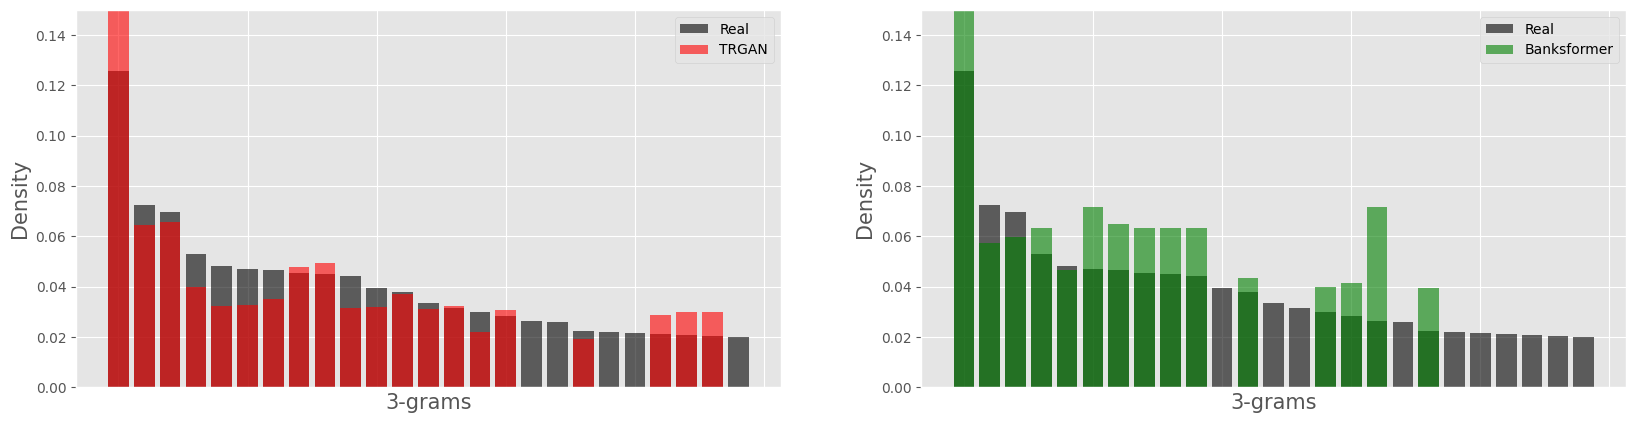

In [320]:
compare_categorical_w_banksformer_3grams(data[['mcc', 'customer']], synth_df[['mcc', 'customer']], synth_df_cat, X_oh, metadata, \
            cat_columns, synth_banksformer.sample(len(data))[['mcc', 'customer']],\
            epochs=1, n_samples=len(data), comp_col='mcc', load=True, data_customer=data[['customer']])